# Práctica 5: Modelo Browniano Geométrico

**Introducción:**

El objetivo de esta práctica es valorar opciones europeas (Call y Put) utilizando modelos binomiales que son consistentes con el Proceso Browniano Geométrico (GBM), el modelo subyacente de Black-Scholes. A diferencia del modelo de Cox-Ross-Rubinstein (CRR) simple, aquí los factores de subida y bajada del árbol se calibran a la volatilidad ($\sigma$) y la deriva ($\mu$ o $r$) del proceso continuo


**Apartado a)** Realiza  1000  simulaciones del modelo bajo la medida neutral al riesgo. Repite el mismo número de simulaciones para el proceso equivalente  𝑊 . Compara los histogramas de ambas muestras para los distintos valores de  𝑗  dados.

In [1]:
import numpy as np
# ============================================================================
# DEFINIMOS LOS PARÁMETROS
# ============================================================================
S0 = 100
sigma = 0.2
r = 0.05
mu = 0.10
T = 1
N = 1000 #
tau = T/N # tamaño del paso temporal
sqrtau = np.sqrt(tau) # raíz de tau
v = sigma*sqrtau
q = 1/2 - sqrtau*(mu-r)/(2*sigma)# la probabilidad neutral al riesgo en mod. Browniano Geométrico

Definimos 𝑀 como el número de simulaciones. Podemos hacer todas las elecciones de la variable aleatoria  𝑋  de una sola vez y ponerlas en una matriz de tamaño 𝑀×𝑁. Primero con la probabilidad  𝑞 .

In [2]:
M = 1000 # número de "caminos" de la muestra
X = np.random.choice([-1,1], size=(M,N), replace=True, p=[1-q,q]) # random.choice elige en el conjunto de valores,
# en este caso con reemplazo y con la probabilidad dada

Todos los valores de $X$ están guardados, para cada camino e instante de tiempo. Tengamos en cuenta que el modelo discreto es:
$$
S_{n}=S_{n-1} * (1 + \mu\tau + \sigma\sqrt{\tau}X_n)
$$
por lo tanto podemos obtener el valor final de $S$ por medio de la función  `cumprod`:

In [3]:
F = 1 + mu * tau + v * X # matriz de MxN
ST = S0 * (np.cumprod(F,axis=1)[:,-1]) # calculamos el valor acumulado y nos quedamos con la última columna

en la última columna de `ST` tenemos almacenados los valores finales del precio.

Generamos ahora una muestra para $W$ usando la probabilidad 1/2 y la deriva $r$:

In [4]:
W = np.random.choice([-1,1], size=(M,N), replace=True, p=[1/2,1/2])
F = 1+ r * tau + v * W # la deriva cambia a r
ST_tilde = S0 * np.cumprod(F,axis=1)[:,-1]

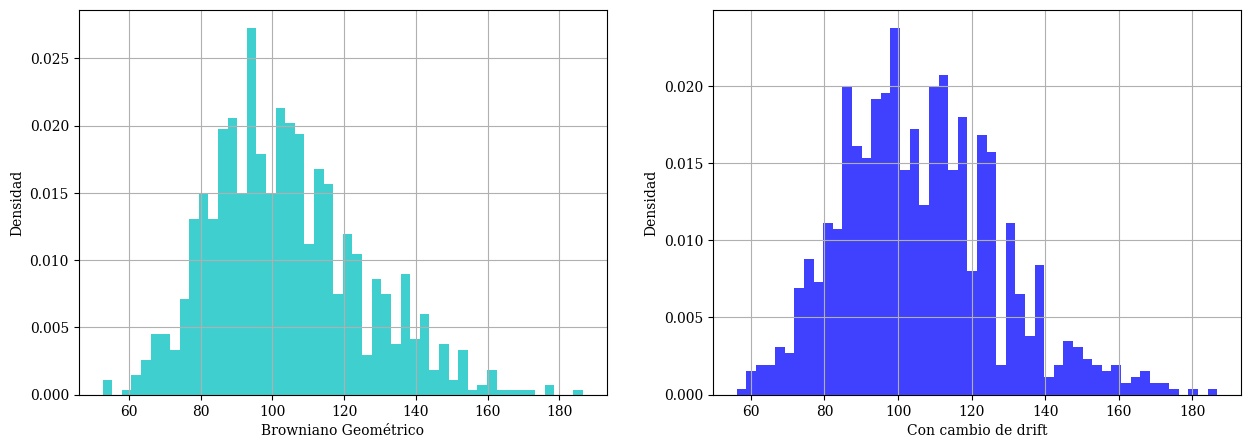

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure(1)

plt.subplot(121)
plt.hist(ST,50, density=True, facecolor='c', alpha=0.75) # density=True indica que se hace la gráfica de la frecuencia relativa "por unidad de longitud"
plt.xlabel('Browniano Geométrico')
plt.ylabel('Densidad')
plt.grid(True)


plt.subplot(122)
plt.hist(ST_tilde,50, density=True, facecolor='b', alpha=0.75) # density=True indica que se hace la gráfica de la frecuencia relativa "por unidad de longitud"
plt.xlabel('Con cambio de drift')
plt.ylabel('Densidad')
plt.grid(True)


plt.show()

**Apartado b)** Utilizando el árbol binomial recombinante basado en la variable $\tilde{X}$ y la medida neutral al riesgo $q$ calcula el precio de una opción de compra $C$ y de la opción de venta $P$ con valor strike $K=110$ (el mismo para las dos). Cambia el valor de la deriva $\mu$ al $20\%$ recalcula la media y los precios, ¿qué se observa?

In [6]:
# ============================================================================
# PARTE (b) - ÁRBOL BINOMIAL CON VARIABLE tilde_X
# ============================================================================

print("\n" + "="*70)
print("PARTE (b) - ÁRBOL BINOMIAL CON VARIABLE X_tilde")
print("="*70)

def arbol_binomial_Xtilde(N, mu_val, r_val, K):
    """
    Árbol binomial basado en la variable tilde_X con probabilidad q
    según la teoría del PDF
    """
    tau = T/N
    sqrtau = np.sqrt(tau)

    # Probabilidad neutral al riesgo q
    q = 0.5 - (mu_val - r_val) * sqrtau / (2 * sigma)

    # Factores de crecimiento
    u_factor = 1 + mu_val * tau + sigma * sqrtau  # X_n = +1
    d_factor = 1 + mu_val * tau - sigma * sqrtau  # X_n = -1

    # Inicializar matriz de precios
    S = np.zeros((N+1, N+1))
    S[0, 0] = S0

    # Construir árbol forward
    for i in range(N):
        for j in range(i+1):
            S[j, i+1] = S[j, i] * u_factor
            S[j+1, i+1] = S[j, i] * d_factor

    # Matrices para valores de opciones
    C = np.zeros((N+1, N+1))  # Call
    P = np.zeros((N+1, N+1))  # Put

    # Payoffs en tiempo final
    for j in range(N+1):
        C[j, N] = max(S[j, N] - K, 0)
        P[j, N] = max(K - S[j, N], 0)

    # Backward induction
    discount = np.exp(-r_val * tau)  # Composición continua
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            C[j, i] = discount * (q * C[j, i+1] + (1-q) * C[j+1, i+1])
            P[j, i] = discount * (q * P[j, i+1] + (1-q) * P[j+1, i+1])

    return C[0, 0], P[0, 0], q


N_valores = [10, 100, 1000]
K = 110

# Calcular para mu = 10%
mu1 = 0.10
print(f"\nPara μ = {mu1*100}% (original):")
print("-" * 50)
print(f"{'N':<8} {'q':<12} {'Call':<12} {'Put':<12} {'Call+Put':<12}")
print("-" * 50)

precios_mu10 = []
for N in N_valores:
    C_precio, P_precio, q_val = arbol_binomial_Xtilde(N, mu1, r, K)
    precios_mu10.append((C_precio, P_precio))
    print(f"{N:<8} {q_val:<12.6f} {C_precio:<12.6f} {P_precio:<12.6f} {C_precio+P_precio:<12.6f}")

# Calcular para mu = 20%
mu2 = 0.20
print(f"\n\nPara μ = {mu2*100}% (modificado):")
print("-" * 50)
print(f"{'N':<8} {'q':<12} {'Call':<12} {'Put':<12} {'Call+Put':<12}")
print("-" * 50)

precios_mu20 = []
for N in N_valores:
    C_precio, P_precio, q_val = arbol_binomial_Xtilde(N, mu2, r, K)
    precios_mu20.append((C_precio, P_precio))
    print(f"{N:<8} {q_val:<12.6f} {C_precio:<12.6f} {P_precio:<12.6f} {C_precio+P_precio:<12.6f}")

# Comparar medias
print(f"\nComparación de precios promedio (Call+Put)/2:")
print(f"Para μ = 10%: {np.mean([(c+p)/2 for c,p in precios_mu10]):.6f}")
print(f"Para μ = 20%: {np.mean([(c+p)/2 for c,p in precios_mu20]):.6f}")
print(f"Diferencia: {np.mean([(c+p)/2 for c,p in precios_mu20]) - np.mean([(c+p)/2 for c,p in precios_mu10]):.6f}")

print("\n OBSERVACIÓN (Parte b):")
print("En este método, los precios SÍ dependen de μ, lo cual es incorrecto")
print("según la teoría de valoración neutral al riesgo")



PARTE (b) - ÁRBOL BINOMIAL CON VARIABLE X_tilde

Para μ = 10.0% (original):
--------------------------------------------------
N        q            Call         Put          Call+Put    
--------------------------------------------------
10       0.460472     5.930071     10.577765    16.507836   
100      0.487500     6.049780     10.686266    16.736046   
1000     0.496047     6.039952     10.675313    16.715265   


Para μ = 20.0% (modificado):
--------------------------------------------------
N        q            Call         Put          Call+Put    
--------------------------------------------------
10       0.381415     5.897001     10.544696    16.441697   
100      0.462500     6.008409     10.644895    16.653304   
1000     0.488141     6.038597     10.673959    16.712556   

Comparación de precios promedio (Call+Put)/2:
Para μ = 10%: 8.326524
Para μ = 20%: 8.301259
Diferencia: -0.025265

 OBSERVACIÓN (Parte b):
En este método, los precios SÍ dependen de μ, lo cual es inc

**Apartado c)** Calcula los precios pedidos en b) pero ahora utilizando un árbol basado en la variable $W$, es decir, aplicando el cambio de medida explicado en la teoría.

In [7]:
# ============================================================================
# PARTE (c) - ÁRBOL BINOMIAL CON VARIABLE W_n (CAMBIO DE MEDIDA)
# ============================================================================
print("\n" + "="*70)
print("PARTE (c) - ÁRBOL BINOMIAL CON VARIABLE W_n (CAMBIO DE MEDIDA)")
print("="*70)

def arbol_binomial_W(N, mu_val, r_val, K):
    """
    Árbol binomial basado en la variable W_n con probabilidad 1/2
    Aplicando el cambio de medida según la teoría del PDF
    """
    tau = T/N
    sqrtau = np.sqrt(tau)

    # Probabilidad fija = 1/2
    p = 0.5

    # Factores de crecimiento (con cambio de medida)
    u_factor = 1 + r_val * tau + sigma * sqrtau  # W_n = +1
    d_factor = 1 + r_val * tau - sigma * sqrtau  # W_n = -1

    # Inicializar matriz de precios
    S = np.zeros((N+1, N+1))
    S[0, 0] = S0

    # Construir árbol forward
    for i in range(N):
        for j in range(i+1):
            S[j, i+1] = S[j, i] * u_factor
            S[j+1, i+1] = S[j, i] * d_factor

    # Valoración de opciones
    C = np.zeros((N+1, N+1))  # Call
    P = np.zeros((N+1, N+1))  # Put

    # Payoffs en tiempo final
    for j in range(N+1):
        C[j, N] = max(S[j, N] - K, 0)
        P[j, N] = max(K - S[j, N], 0)

    # Backward induction
    discount = np.exp(-r_val * tau)
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            C[j, i] = discount * (p * C[j, i+1] + (1-p) * C[j+1, i+1])
            P[j, i] = discount * (p * P[j, i+1] + (1-p) * P[j+1, i+1])

    return C[0, 0], P[0, 0]

print(f"\nAplicando cambio de medida (independiente de μ):")
print(f"\nPara μ = {mu1*100}% (original):")
print("-" * 50)
print(f"{'N':<8} {'Call':<12} {'Put':<12} {'Call+Put':<12}")
print("-" * 50)

precios_W_mu10 = []
for N in N_valores:
    C_precio, P_precio = arbol_binomial_W(N, mu1, r, K)
    precios_W_mu10.append((C_precio, P_precio))
    print(f"{N:<8} {C_precio:<12.6f} {P_precio:<12.6f} {C_precio+P_precio:<12.6f}")

print(f"\n\nMismo cálculo con μ = {mu2*100}% (debería dar igual):")
print(f"\nPara μ = {mu2*100}% (original):")
print("-" * 50)
print(f"{'N':<8} {'Call':<12} {'Put':<12} {'Call+Put':<12}")
print("-" * 50)

prices_W_mu20 = []
for N in N_valores:
    C_precio, P_precio = arbol_binomial_W(N, mu2, r, K)
    prices_W_mu20.append((C_precio, P_precio))
    print(f"{N:<8} {C_precio:<12.6f} {P_precio:<12.6f} {C_precio+P_precio:<12.6f}")



PARTE (c) - ÁRBOL BINOMIAL CON VARIABLE W_n (CAMBIO DE MEDIDA)

Aplicando cambio de medida (independiente de μ):

Para μ = 10.0% (original):
--------------------------------------------------
N        Call         Put          Call+Put    
--------------------------------------------------
10       6.191484     10.839178    17.030662   
100      6.052366     10.688852    16.741218   
1000     6.039780     10.675142    16.714922   


Mismo cálculo con μ = 20.0% (debería dar igual):

Para μ = 20.0% (original):
--------------------------------------------------
N        Call         Put          Call+Put    
--------------------------------------------------
10       6.191484     10.839178    17.030662   
100      6.052366     10.688852    16.741218   
1000     6.039780     10.675142    16.714922   
